 <h1>Table of Contents<span class="tocSkip"></span></h1>

<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li>
        <li><span><a href="#Pre-requisites" data-toc-modified-id="Pre-requisites-2">Pre-requisites</a></span></li>
        <li><span><a href="#Data-Used" data-toc-modified-id="Data Used-3">Data Used</a></span></li>
        <li><span><a href="#Defining-the-constants" data-toc-modified-id="Defining the constants-4">Defining the constants</a></span></li>
        <li><span><a href="#Necessary-Imports" data-toc-modified-id="Necessary Imports-5">Necessary Imports</a></span></li>
        <li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-10">Conclusion</a></span></li>
    </ul>
</div>

## Introduction

The sample code uses Computer Vision techniques to automatically register scanned images of any part of the world onto the world map and hence overlay the species hotspots depicted in the scanned images onto the world map.

### What is the Half Earth Project all about?
The Half Earth Project advocates the conservation of half of the Earth in order to combat species extinction crisis and preserve Mother Earth for the generations to come.

### How to identify which half of the Earth to conserve ?
One visual approach is to map global species distribution and use this information to identify the regions rich in biodiversity.However, mapping thousands of species all across the globe requires a lot of “manual” work to do. This sample demonstrates how the mapping process can be automated by using Computer Vision techniques. The expected inputs and final output are shown below:

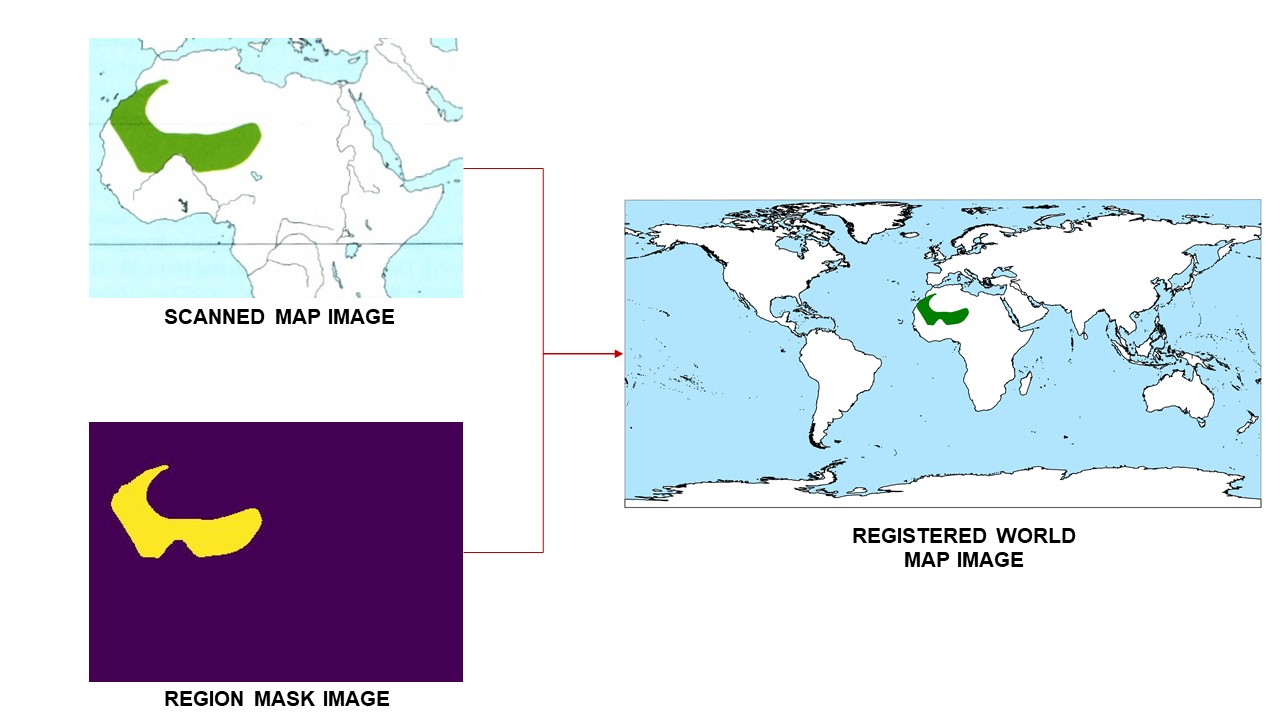

## Pre-requisites
OpenCV library: This sample requires installation of OpenCV library. Kindly install OpenCV using the following command:

pip install opencv-contrib-python==4.2.0.34

## Data Used
The data used for this sample are the scanned images from a map notebook and the corresponding species region masks. Please click here for downloading sample data. Sample inputs are shown below:

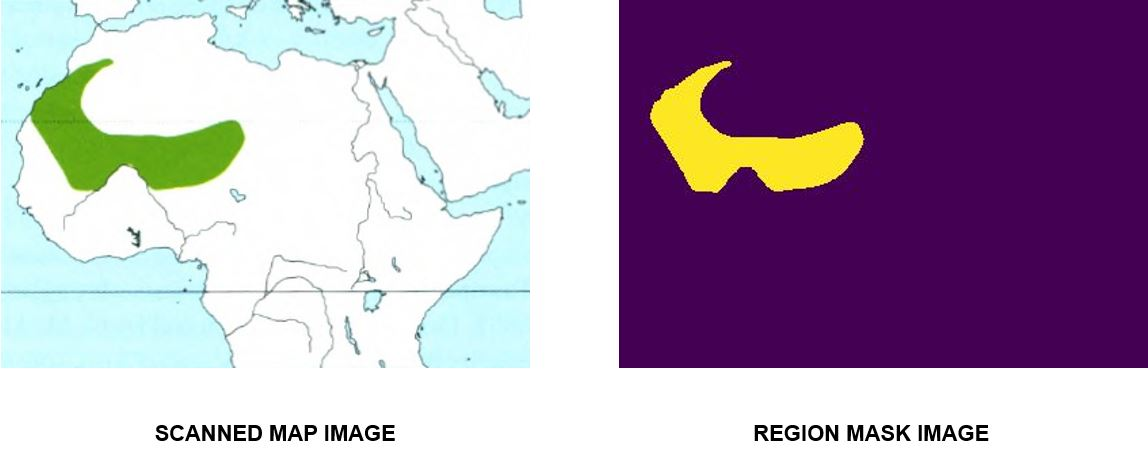

## Defining the constants
The following constants need to be defined before running the sample. The values need to be tweaked based on the type/quality of input. The results of the notebook will vary based on the values provided.

In [ ]:
# Path to the folder where the scanned map images are placed
IMAGES_TO_REGISTER_FOLDER = r"C:\Users\ati11038\Documents\workspace\data" \
                            r"\half_earth\extracted_samples\extracted_maps"

# Path to the folder where the species region mask images are placed
IMAGES_TO_REGISTER_SPECIES_MASKS_FOLDER = r"C:\Users\ati11038\Documents" \
                                         r"\workspace\data\half_earth\extracted_samples" \
                                          r"\extracted_masks"

# File path and filename of world image file 
WORLD_MAP_IMAGE_PATH = r"C:\Users\ati11038\Documents\workspace\data\half_earth\world_map"
WORLD_MAP_IMAGE_NAME = "map_without_rivers.tif"

# Path to the folder where the outputs need to appear
RESULTS_FOLDER = r"C:\\Users\\ati11038\\Documents\\workspace\\data\\half_earth\\results\\main" \
                 r"\\23_4_2020\\4"

# Minimum expected IOU of homography transform result with reference homography
# to qualify as improved homography
# (float: 0.0 - 1.0)
IOU_THRESHOLD_HOMOGRAPHY = 0.85

# Minimum expected spread of estimated control points over the scanned image
# (float: 0.0 - 1.0)
CONTOUR_RECT_AREA_RATIO_THRESHOLD = 0.40

# Division factor w.r.t diagonal of template for estimating size of contour patch
# (int: 8 - 12)
CONTOUR_PATCH_SIZE_FACTOR = 8

# Maximum allowed non zero pixels in contour patch to be selected for matching
# (float: 0.0 - 1.0)
CONTOUR_PATCH_NON_ZERO_THRESHOLD = 0.6

# Maximum allowed non zero pixels in world map patch to be selected for matching
# (float: 0.0 - 1.0)
WORLD_MAP_PATCH_NON_ZERO_THRESHOLD = 0.6

# Multiplication factor w.r.t contour patch for estimating size of world map patch
# (float: 1.0 - 5.0)
WORLD_MAP_PATCH_SIZE_FACTOR = 2.5

# Maximum allowed distance of control points from the nearest contour point
# for control point refinement
# (int: 1 - 10) 
REFINEMENT_DISTANCE_THRESHOLD = 5

# Minimum threshold for segmenting mask from species region mask image
# (int: 1 - 255)
SPECIES_REGION_MASK_THRESHOLD = 50
SPECIES_REGION_MASK_VALUE = 255

# Upper and lower thresholds for homogenizing query image
# (int: 1 - 255)
HOMOGENIZE_UPPER_THRESHOLD = 245

# Boundary values for latitude and longitude corresponding to world map image
LONGITUDE_EXTREME_LEFT = -180
LATITUDE_EXTREME_TOP = 85
LONGITUDE_EXTREME_RIGHT = 180
LATITUDE_EXTREME_BOTTOM = -85

# Maximum number of control points needed 
MAX_CONTROL_POINTS = 8

## Necessary Imports
The packages defined below are used throughout the notebook.

In [ ]:
import cv2
import imutils
import math
import copy
import numpy as np
import os

## Defining helper functions
The following functions are helper functions which are used for general purpose tasks such as writing an image to disk.

In [ ]:
from datetime import datetime
current_image_prefix = ""

def find_current_timestamp():
    """
    Creates a string representing the current timestamp

    :returns: 
        timestamp_str: Current timestamp string in the format "%H_%M_%S_%f"
    """

    datetime_obj = datetime.now()
    timestamp_str = datetime_obj.strftime("%H_%M_%S_%f")
    return timestamp_str

In [ ]:
def write_image_to_disk(image_to_write, image_suffix):
    """
    Saves image to disk

    :param image_to_write: Image which needs to be written to disk
    :param image_suffix: Suffix for the image name to be formed
    
    :returns: 
        None
    """
    image_dir = RESULTS_FOLDER + "\\" + current_image_prefix
    
    # Create directory if it does not exist
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    
    image_name = current_image_prefix + "_" + image_suffix
    image_path =  image_dir + "\\" + find_current_timestamp()\
                  + "_" + image_name + ".jpg"
    
    cv2.imwrite(image_path, image_to_write)

## Defining pre-processing functions
The following functions are used for image processing tasks such as filling extraneous features in a binary image and filling specific regions of the image. For best results, the images need to be of good quality (with clear edges). 

In [ ]:
def preprocess(input_img, kernel_size):
    """
    Create a binary mask and get rid of features such as rivers, discontinuities

    :param input_img: Input image to be registered on the world map
    :param kernel_size: Kernel size for morphological operation

    :return
        preprocessed_img: Image without features such as rivers, discontinuities
    """

    if input_img.ndim != 2:
        input_img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    else:
        input_img_gray = input_img

    input_height = input_img_gray.shape[0]
    input_width = input_img_gray.shape[1]

    binary_mask = np.zeros((input_height, input_width),
                           dtype=np.uint8)

    for y in range(0, input_height):
        for x in range(0, input_width):
            if input_img_gray[y][x] > HOMOGENIZE_UPPER_THRESHOLD:
                binary_mask[y][x] = 255

    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    binary_mask_closed = cv2.morphologyEx(binary_mask,
                                          cv2.MORPH_CLOSE, kernel)

    binary_mask_closed_eroded = cv2.erode(binary_mask_closed,
                                          kernel, iterations=1)

    preprocessed_img = np.zeros((input_height, input_width),
                                dtype=np.uint8)

    for y in range(0, input_height):
        for x in range(0, input_width):
            if binary_mask_closed_eroded[y][x] == 255:
                preprocessed_img[y][x] = 255
            else:
                # modified_input_img[y][x] = input_img[y][x]
                preprocessed_img[y][x] = input_img_gray[y][x]

    return preprocessed_img

In [ ]:
def homogenize(input_img):
    """
    Converts color image to binary image with landmass depicted in white and
    other regions depicted in black, also filling the species region pixels

    :param input_img: Input image to be homogenized

    :returns:
        homogenized_img: Homogenized Image
    """

    if input_img.ndim != 2:
        input_img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    else:
        input_img_gray = input_img

    homogenized_img = np.zeros((input_img_gray.shape[0],
                                input_img_gray.shape[1]), dtype=np.uint8)

    input_img_height = input_img_gray.shape[0]
    input_img_width = input_img_gray.shape[1]

    for y in range(0, input_img_height):
        for x in range(0, input_img_width):
            if input_img_gray[y][x] >= HOMOGENIZE_UPPER_THRESHOLD:
                homogenized_img[y][x] = 255
            else:
                homogenized_img[y][x] = 0

    return homogenized_img

In [ ]:
def create_region_mask(mask_img):
    """
    Create binary mask for species region using the original color species region image

    :param mask_img: Color image of species mask
    
    :returns: 
        mask_img: Mask representing species region
    """

    mask_img_gray = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
    ret, mask_img = cv2.threshold(mask_img_gray,
                                  SPECIES_REGION_MASK_THRESHOLD,
                                  SPECIES_REGION_MASK_VALUE,
                                  cv2.THRESH_BINARY)
    
    return mask_img


In [ ]:
def fill_mask_pixels(input_img, mask):
    """
    Fills the mask pixels of image with white

    :param input_img: Color map image with species region
    :param mask: Binary mask image of species region
    
    :returns: 
        input_img_copy: Filled color image
    """

    input_img_copy = input_img.copy()

    mask_height = mask.shape[0]
    mask_width = mask.shape[1]

    for y in range(0, mask_height):
        for x in range(0, mask_width):
            if mask[y][x] == 255:
                input_img_copy[y][x][0] = 255
                input_img_copy[y][x][1] = 255
                input_img_copy[y][x][2] = 255

    return input_img_copy


## Defining computation helper functions
The following functions are math functions utilized by the core algorithmic modules. 

In [ ]:
def calculate_distance(point1_x, point1_y, point2_x, point2_y):
    """
    Find distance between two points
    point1_x: x coordinate of first point
    point1_y: y coordinate of first point
    point2_x: x coordinate of second point
    point2_y: y coordinate of second point

    :returns:
        distance: Euclidean distance between two points
    """

    distance = math.sqrt((point1_x - point2_x) ** 2 
                         + (point1_y - point2_y) ** 2)
    return distance


In [ ]:
def calculate_diagonal_length(length, height):
    """
    Find the length of diagonal of a rectangle

    :param length: Length of rectangle
    :param height: Height of rectangle

    :returns:
        length_diag: Length of the diagonal
    """

    length_diag = math.sqrt((length)** 2 + (height)** 2)

    return length_diag

In [ ]:
def add_offset_to_points(input_contour, offset_x, offset_y):
    """
    Add offset to points on contour

    :param input_contour: Contour which needs to be processed
    :param offset_x: Offset which needs to be added in x co-ordinate
    :param offset_y: Offset which needs to be added in y co-ordinate

    :returns: 
        input_contour: Contour with offsetted points
    """

    for point in input_contour:
        point[0][0] += offset_x
        point[0][1] += offset_y

    return input_contour

In [ ]:
def calculate_nonzero_ratio(input_img):
    """
    Calculates the ratio of non zero pixels area w.r.t entire area of image
    
    :param: input_img: Image for which ratio needs to be computed
    
    :returns:
        ratio: Non-zero area ratio
    """
    
    non_zero_area = cv2.countNonZero(input_img)
    total_area = input_img.shape[0] * input_img.shape[1]

    ratio = non_zero_area / total_area

    return ratio

In [ ]:
def calculate_distance_ratios(bb_start_x, bb_start_y, bb_end_x, bb_end_y, point_x, point_y):
    """
    Calculates ratios of distances for X and Y from starting and ending co-ordinate of 
    X and Y respectively.
    
    :param: bb_start_x: X co-ordinate of left top corner of bounding box
    :param: bb_start_y: Y co-ordinate of left top corner of bounding box
    :param: bb_end_x: X co-ordinate of right bottom corner of bounding box
    :param: bb_end_y: Y co-ordinate of right bottom corner of bounding box
    :param: point_x: X co-ordinate of the point for which ratios need to be computed
    :param: point_y: Y co-ordinate of the point for which ratios need to be computed
    
    :returns:
        ratio_x: Ratio of distance of x co-ordinate of point from starting and ending
                 x co-ordinates of bounding box
        ratio_y: Ratio of distance of y co-ordinate of point from starting and ending
                 y co-ordinates of bounding box
    """

    # For numerical stability
    epsilon = 0.00001
        
    distance_point_x_start_x = point_x - bb_start_x
    distance_point_x_end_x = bb_end_x - point_x

    distance_point_y_start_y = point_y - bb_start_y
    distance_point_y_end_y = bb_end_y - point_y

    ratio_x = (distance_point_x_start_x / (distance_point_x_end_x + epsilon))

    ratio_y = (distance_point_y_start_y / (distance_point_y_end_y + epsilon))
    
    return ratio_x, ratio_y

In [ ]:
def check_bb_boundary(bb_start_x, bb_start_y, bb_end_x, bb_end_y, height, width):
    """
    Checks the boundary and modifies the values if necessary
    
    :param: bb_start_x: X co-ordinate of left top corner of bounding box
    :param: bb_start_y: Y co-ordinate of left top corner of bounding box
    :param: bb_end_x: X co-ordinate of right bottom corner of bounding box
    :param: bb_end_y: Y co-ordinate of right bottom corner of bounding box
    :param: height: Height of the image
    :param: width: Width of the image
    
    :returns:
        bb_start_x: Modified X co-ordinate of left top corner of bounding box
        bb_start_y: Modified Y co-ordinate of left top corner of bounding box
        bb_end_x: Modified X co-ordinate of right bottom corner of bounding box
        bb_end_y: Modified Y co-ordinate of right bottom corner of bounding box
    """
    if bb_start_x < 0:
        bb_start_x = 0
   
    if bb_start_y < 0:
        bb_start_y = 0

    if bb_end_x >= width:
        bb_end_x = width - 1

    if bb_end_y >= height:
        bb_end_y = height - 1

    return bb_start_x, bb_start_y, bb_end_x, bb_end_y

In [ ]:
def create_random_color_list(size):
    """
    Generate a list of specified size with random color values

    :param size: Size of the list which needs to be returned

    :returns:
       color_list: List of random color values
    """

    color_list = []

    for i in range(0, size):
        color_tuple = tuple(np.random.choice(range(256), size=3))
        color_tuple = tuple([int(x) for x in color_tuple])
        color_list.append(color_tuple)

    return color_list

In [ ]:
def calculate_iou_binary_images(image1, image2):
    """
    Calculate iou using two binary images

    :param image1: First binary image
    :param image2: Second binary image

    :returns:
        iou(float): Computed IOU value 
    """

    intersection_img = cv2.bitwise_and(image1, image2)
    intersection_pixels = cv2.countNonZero(intersection_img)

    union_img = cv2.bitwise_or(image1, image2)
    union_pixels = cv2.countNonZero(union_img)

    iou = intersection_pixels / union_pixels

    return iou


## Defining core algorithm functions
The following functions are the core algorithmic functions used to compute the transform for the scanned images onto the world map.

In [ ]:
def detect_contours(input_img):
    """
    Detects contours in the input image
    
    :param input_img : Input image for which contours need to be computed
    
    :returns:
        contours : List of computed contours for the input image
    """
    if input_img.ndim != 2:
        input_img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    else:
        input_img_gray = input_img

    ret, input_img_gray_thresh = cv2.threshold(input_img_gray, 127, 255, 0)

    contours, hierarchy = cv2.findContours(input_img_gray_thresh,
                                           cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours

In [ ]:
def detect_template(template, search_img, start_scale, end_scale, num_scales):
    """
    Performs template matching to locate the template in the world map

    :param template: Template image which needs to be registered on the world map
    :param search_img: Image in which template needs to be searched
    :param start_scale: Starting value of scale interval
    :param end_scale: Ending value of scale interval
    :param num_scales: Number of scales within the scale interval

    :returns:
        start_x: Starting X co-ordinate of detected bounding box
        start_y: Starting Y co-ordinate of detected bounding box
        end_x: Ending X co-ordinate of detected bounding box
        end_y: Ending Y co-ordinate of detected bounding box
        max_val: Value of template match score for the detected bounding box
        scale_factor: Scale at which the match was found for the template

    """

    template_height = template.shape[0]
    template_width = template.shape[1]

    start_x = 0
    start_y = 0
    end_x = 0
    end_y = 0
    max_val = -1

    found = None
    # match_map_img = None

    # loop over the scales of the image
    for scale in np.linspace(start_scale, end_scale, num_scales)[::-1]:
        # resize the image according to the scale, and keep track
        # of the ratio of the resizing
        resized = imutils.resize(search_img,
                                 width=int(search_img.shape[1] * scale))

        scale_factor = search_img.shape[1] / float(resized.shape[1])

        # If the resized image is smaller than the template, then break
        # from the loop
        if resized.shape[0] < template_height or resized.shape[1] < template_width:
            break

        # Match the template in the resized image and store the result image
        result = cv2.matchTemplate(resized, template, cv2.TM_CCOEFF)

        # Find the maximum template match score and location in the result image
        (_, max_val, _, max_loc) = cv2.minMaxLoc(result)

        # If there is a new maximum correlation value, then update
        # the bookkeeping variable
        if found is None or max_val > found[0]:
            found = (max_val, max_loc, scale_factor)
            # match_map_img = result

    # Check if we have found a match
    if found is not None:

        # Unpack the bookkeeping variable and compute the (x, y) coordinates
        # of the bounding box based on the resized ratio
        (max_val, max_loc, scale_factor) = found
        (start_x, start_y) = (int(max_loc[0] * scale_factor), int(max_loc[1] * scale_factor))
        (end_x, end_y) = (int((max_loc[0] + template_width) * scale_factor),
                          int((max_loc[1] + template_height) * scale_factor))
    else:
        max_val = -1

    return start_x, start_y, end_x, end_y, max_val, scale_factor

In [ ]:
def find_nearest_contour_point(input_contour, pt_x, pt_y):
    """
    Find point on contour which is nearest to the given point
    
    :param input_contour: Contour on which points needs to be evaluated for nearness
    :param pt_x: X co-ordinate of point
    :param pt_y: Y co-ordinate of point
    
    :returns:
        min_x: X co-ordinate of contour point nearest to input point
        min_y: Y co-ordinate of contour point nearest to input point
        min_index: Index of contour point nearest to input point
        min_distance: Distance of contour point nearest to input point
    """

    distance = cv2.pointPolygonTest(contour, (pt_x, pt_y), True)

    min_distance = float("inf")
    min_index = -1
    min_x = -1
    min_y = -1

    for i, contour_pt in enumerate(contour):
        distance = find_distance(contour_pt[0][0], contour_pt[0][1], pt_x, pt_y)

        if distance < min_distance:
            min_distance = distance
            min_index = i
            min_x = contour_pt[0][0]
            min_y = contour_pt[0][1]

    return min_x, min_y, min_index, min_distance

In [ ]:
def compute_refined_homography_outlier_mask(control_pts):
    """
    Computes homography from mapped control points and outlier mask using RANSAC

    :param control_pts: List of control points in both query image and world map
                        co-ordinates

    :returns:
        homography_matrix: Computed Homography matrix
        outlier_mask: Mask array with flags indicating whether control points inlier or not
    """

    if len(control_pts) < 4:
        return None, None

    src_points = np.zeros((len(control_pts), 2), dtype=np.float32)
    dst_points = np.zeros((len(control_pts), 2), dtype=np.float32)

    for i, control_pt in enumerate(control_pts):
        src_points[i, 0] = control_pt[0]
        src_points[i, 1] = -1 * control_pt[1]
        dst_points[i, 0] = control_pt[5]
        dst_points[i, 1] = -1 * control_pt[6]

    homography_matrix, outlier_mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 4)

    return homography_matrix, outlier_mask

In [ ]:
def compute_reference_homography(bb_start_x, bb_start_y,
                                 bb_end_x, bb_end_y,
                                 world_map_height, world_map_width,
                                 template_height, template_width):
    """
    Computes the homography transform mapping query image onto world map

    :param bb_start_x : bounding box left x co-ordinate
    :param bb_start_y : bounding box top y co-ordinate
    :param bb_end_x : bounding box right x co-ordinate
    :param bb_end_y : bounding box bottom x co-ordinate
    :param world_map_height: Height of world map
    :param world_map_width: Width of world map
    :param template_height: Height of template image
    :param template_width: Width of template image

    :returns:
        homography_matrix : Computed transformation matrix
    """

    src_points = np.array([[0, 0],
                           [template_width - 1, 0],
                           [template_width - 1, template_height - 1],
                           [0, template_height - 1]],
                          dtype=np.float32)

    dst_points = np.array([[bb_start_x, bb_start_y],
                           [bb_end_x, bb_start_y],
                           [bb_end_x, bb_end_y],
                           [bb_start_x, bb_end_y]],
                          dtype=np.float32)

    # Compute the reference homography using perspective transform function of OpenCV
    homography_matrix = cv2.getPerspectiveTransform(src_points, dst_points)

    return homography_matrix

In [ ]:
def annotate_control_pts(world_map, query_image, control_pts):
    """
    Annotate control points on world map and query image
    
    :param: world_map: Color image of world map
    :param: query_image: Query image
    :param: control_pts: Control points to be annotated
    
    :returns:
        world_map_img_copy: Annotated world map image
        query_image_copy: Annotated query image
    """
    world_map_img_copy = world_map.copy()
    query_image_copy = query_image.copy()

    colors = create_random_color_list(len(control_pts))

    for i, control_pt in enumerate(control_pts):
        color = colors[i]
        color = tuple([int(x) for x in color])

        query_image_copy = cv2.drawMarker(query_image_copy,
                                          (control_pt[0], -1 * control_pt[1]), color)

        world_map_img_copy = cv2.drawMarker(world_map_img_copy,
                                            (int(control_pt[5]), int(-1 * control_pt[6])), color)

    return world_map_img_copy, query_image_copy

In [ ]:
def filter_control_pts(control_pts, outlier_mask):
    """
    Filter outliers from control points using outlier mask
    
    :param: control_pts: Input control points to be filtered
    :param: outlier_mask: Outlier mask with flags indicating whether outlier or not
    
    :returns:
        filtered_control_pts: Control Points without outliers
    """
    filtered_control_pts = []

    for i, control_pt in enumerate(control_pts):
        if outlier_mask[i] == 1:
            filtered_control_pts.append(control_pt)

    return filtered_control_pts

In [ ]:
def refine_control_pts(control_pts, world_map_contour_processed):
    """
    Refines already detected control points using world map contour matching with
    biggest contour in query image
    
    :param control_pts: control points to be refined
    :param world_map_contour_processed: Offsetted world map contour

    :returns:
        control_pts: Refined control points
    """

    for control_pt in control_pts:
        min_x, min_y, min_index, min_distance = find_nearest_point_on_contour(
            world_map_contour_processed, control_pt[5],-1 * control_pt[6])

        if min_index > 0 and min_distance < REFINEMENT_DISTANCE_THRESHOLD:
            control_pt[5] = min_x
            control_pt[6] = -1 * (min_y)
            control_pt[2] = LONGITUDE_EXTREME_LEFT \
                            + (degree_per_pixel_x * min_x)

            control_pt[3] = LATITUDE_EXTREME_TOP \
                            + (degree_per_pixel_y * min_y)

    return control_pts


In [ ]:
def estimate_control_points(world_map_roi_processed, template,
                            world_map_roi_processed_offset_x,
                            world_map_roi_processed_offset_y,
                            world_map_roi_processed_start_x,
                            world_map_roi_processed_start_y,
                            template_warped_start_x,
                            template_warped_start_y,
                            degree_per_pixel_x,
                            degree_per_pixel_y):
    """
    Detects contours in template image and finds correpondences in processed world map image ROI

    :param world_map_roi_processed: Processed world map image ROI
    :param template: Template image
    :param world_map_roi_processed_offset_x: X Margin for world map ROI w.r.t warped template
    :param world_map_roi_processed_offset_y: Y Margin for world map ROI w.r.t warped template
    :param world_map_roi_processed_start_x: X co-ordinate of left top corner of world map roi
    :param world_map_roi_processed_start_y: Y co-ordinate of left top corner of world map roi
    :param template_warped_start_x: X co-ordinate of left top corner of warped template
    :param template_warped_start_y: Y co-ordinate of left top corner of warped template
    :param degree_per_pixel_x: Degrees per pixel in x direction
    :param degree_per_pixel_y: Degrees  per pixel in y direction

    :returns:
        mapped_control_pts: List of control points in template and corresponding points in
                            world map
    """
    # Detect contours in world map roi and template
    world_map_roi_contours = detect_contours(world_map_roi_processed)
    template_contours = detect_contours(template)

    # Find the biggest template contour in terms of area
    biggest_template_contour = max(template_contours, key=cv2.contourArea)

    template_contour_img = template.copy()
    template_contour_img = cv2.drawContours(template_contour_img, [biggest_template_contour],
                                            -1, (128, 128, 128), 4)

    write_image_to_disk(template_contour_img, "template_contour_img")

    # Create list of contour points in template for which matches need to be found
    contour_pts = []

    (bb_cnt_xmin, bb_cnt_ymin, bb_cnt_width, bb_cnt_height) = \
        cv2.boundingRect(biggest_template_contour)

    bb_cnt_area = bb_cnt_width * bb_cnt_height
    template_area = template.shape[0] * template.shape[1]

    area_ratio = bb_cnt_area / template_area

    if area_ratio < CONTOUR_RECT_AREA_RATIO_THRESHOLD:
        for contour in template_contours:
            for contour_pt in contour:
                contour_pts.append(contour_pt)

    else:
        contour_pts = biggest_template_contour

    # Initialize parameters for patch matching
    length_diagonal_template_img = calculate_diagonal_length(template.shape[1],
                                                             template.shape[0])
    contour_patch_window = int(length_diagonal_template_img
                               / CONTOUR_PATCH_SIZE_FACTOR)

    delta_contour_patch_window = contour_patch_window / 2

    world_img_patch_window = int(contour_patch_window * WORLD_MAP_PATCH_SIZE_FACTOR)
    delta_world_map_patch_window = (world_img_patch_window / 2)

    mapped_control_pts = []

    for contour_pt in contour_pts:

        contour_pt_x = contour_pt[0][0]
        contour_pt_y = contour_pt[0][1]

        # Create contour patch around contour point
        contour_patch_start_y = contour_pt_y - delta_contour_patch_window
        contour_patch_end_y = contour_pt_y + delta_contour_patch_window
        contour_patch_start_x = contour_pt_x - delta_contour_patch_window
        contour_patch_end_x = contour_pt_x + delta_contour_patch_window

        contour_patch_start_x, contour_patch_start_y, contour_patch_end_x, contour_patch_end_y = \
            check_bb_boundary(contour_patch_start_x, contour_patch_start_y,
                              contour_patch_end_x, contour_patch_end_y,
                              template.shape[0], template.shape[1])

        contour_patch = template[int(contour_patch_start_y): int(contour_patch_end_y),
                        int(contour_patch_start_x): int(contour_patch_end_x)]

        # write_image_to_disk(contour_patch, "contour_patch")

        # Check if contour patch is qualified for matching
        contour_patch_non_zero_ratio = calculate_nonzero_ratio(contour_patch)

        if contour_patch_non_zero_ratio > CONTOUR_PATCH_NON_ZERO_THRESHOLD:
            continue

        world_map_patch_start_y = contour_pt_y - delta_world_map_patch_window \
                                  + world_map_roi_processed_offset_y
        world_map_patch_end_y = contour_pt_y + delta_world_map_patch_window \
                                + world_map_roi_processed_offset_y
        world_map_patch_start_x = contour_pt_x - delta_world_map_patch_window \
                                  + world_map_roi_processed_offset_x
        world_map_patch_end_x = contour_pt_x + delta_world_map_patch_window \
                                + world_map_roi_processed_offset_x

        world_map_patch_start_x, world_map_patch_start_y, world_map_patch_end_x, world_map_patch_end_y = \
            check_bb_boundary(world_map_patch_start_x, world_map_patch_start_y,
                              world_map_patch_end_x, world_map_patch_end_y,
                              world_map_roi_processed.shape[0], world_map_roi_processed.shape[1])

        world_map_patch = world_map_roi_processed[int(world_map_patch_start_y): int(world_map_patch_end_y),
                          int(world_map_patch_start_x): int(world_map_patch_end_x)]

        # write_image_to_disk(world_map_patch, "world_map_patch")

        # Check if world map patch is qualified for matching
        world_img_patch_non_zero_ratio = calculate_nonzero_ratio(world_map_patch)

        if world_img_patch_non_zero_ratio > WORLD_MAP_PATCH_NON_ZERO_THRESHOLD:
            continue

        detection_start_x, detection_start_y, detection_end_x, detection_end_y, detection_val, scale_factor = \
            detect_template(contour_patch, world_map_patch, 1.0, 1.0, 1)

        if detection_val > 0:
            # Compute centroid in detected world map patch
            ratio_x, ratio_y = \
                calculate_distance_ratios(contour_patch_start_x, contour_patch_start_y,
                                          contour_patch_end_x, contour_patch_end_y,
                                          contour_pt_x, contour_pt_y)

            world_map_patch_centroid_x = ((ratio_x * detection_end_x) + detection_start_x) / (ratio_x + 1)
            world_map_patch_centroid_y = ((ratio_y * detection_end_y) + detection_start_y) / (ratio_y + 1)

            # Transform centroid to world map co-ordinates
            centroid_world_map_detection_x = world_map_patch_centroid_x \
                                             + world_map_patch_start_x \
                                             + world_map_roi_processed_start_x
            centroid_world_map_detection_y = world_map_patch_centroid_y \
                                             + world_map_patch_start_y \
                                             + world_map_roi_processed_start_y

            # Calculate latitude and longitude co-ordinates
            centroid_world_map_detection_x_long = LONGITUDE_EXTREME_LEFT \
                                                  + (degree_per_pixel_x * centroid_world_map_detection_x)
            centroid_world_map_detection_y_lat = LATITUDE_EXTREME_TOP \
                                                 + (degree_per_pixel_y * centroid_world_map_detection_y)

            mapped_control_pts.append([contour_pt_x, -1 * contour_pt_y,
                                       centroid_world_map_detection_x_long,
                                       centroid_world_map_detection_y_lat,
                                       detection_val, centroid_world_map_detection_x,
                                       -1 * centroid_world_map_detection_y])

    return mapped_control_pts

In [ ]:
def apply_homography(query_img, world_map, homography_matrix):
    """
    Applies estimated homography on template image and returns modified world map

    :param: query_img: Image to be processed
    :param: world_map: World map image
    :param: homography_matrix: Homography matrix to be used

    :returns:
        modified_world_map: Modified world map image
    """

    world_map_height = world_map.shape[0]
    world_map_width = world_map.shape[1]

    warped_query_img = cv2.warpPerspective(query_img, homography_matrix,
                                           (world_map_width, world_map_height))

    modified_world_map = world_map.copy()

    for y in range(0, world_map_height):
        for x in range(0, world_map_width):
            if warped_query_img[y][x][0] != 0:
                modified_world_map[y][x][0] = warped_query_img[y][x][0]
                modified_world_map[y][x][1] = warped_query_img[y][x][1]
                modified_world_map[y][x][2] = warped_query_img[y][x][2]

    return modified_world_map

In [ ]:

def compare_homography_matrices(reference_homography, refined_homography,
                                control_pts, outlier_mask,
                                template, world_map):
    """
    Compares the estimated homographies and selects the better homography

    :param: reference_homography: Estimated reference homography
    :param: refined_homography: Estimated refined homography
    :param: control_pts: Control points used to compute refined homography
    :param: world_map: World map image

    :returns:
        final_homography: Selected homography matrix
    """

    world_map_height = world_map.shape[0]
    world_map_width = world_map.shape[1]

    warped_template_reference_homography = cv2.warpPerspective(template, reference_homography,
                                                               (world_map_width, world_map_height))

    warped_template_refined_homography = cv2.warpPerspective(template, refined_homography,
                                                             (world_map_width, world_map_height))

    warped_template_reference_mask = np.zeros((world_map_height, world_map_width),
                                              dtype=np.uint8)

    warped_template_refined_mask = np.zeros((world_map_height, world_map_width),
                                            dtype=np.uint8)

    for y in range(0, world_map_height):
        for x in range(0, world_map_width):

            if warped_template_reference_homography[y][x] != 0:
                warped_template_reference_mask[y][x] = 255

            if warped_template_refined_homography[y][x] != 0:
                warped_template_refined_mask[y][x] = 255

    iou = calculate_iou_binary_images(warped_template_reference_mask,
                                      warped_template_refined_mask)

    if iou < IOU_THRESHOLD_HOMOGRAPHY:
        return reference_homography, 0
    else:
        return refined_homography, 1

In [ ]:
def map_species_region(region_mask_img, world_map, reference_homography, refined_homography,
                       selected_index, detection_start_x, detection_start_y, detection_end_x,
                       detection_end_y):
    """
    Maps the species region masks on the world map using the computed homography matrices

    :param: region_mask_img: Species region mask depicting species distribution
    :param: world_map: Color image of World Map
    :param: reference_homography: Computed Reference Homography
    :param: refined_homography: Computed Refined Homography
    :param: selected_index: Index indicating which homography matrix is the final computed homography
    :param: detection_start_x: X co-ordinate of the top left corner of detected bounding box
    :param: detection_start_y: Y co-ordinate of the top left corner of detected bounding box
    :param: detection_end_x: X co-ordinate of the bottom right corner of detected bounding box
    :param: detection_end_y: Y co-ordinate of the bottom right corner of detected bounding box

    :returns:
        mapped_species_region: World Map with species region mapped
    """

    world_map_height = world_map.shape[0]
    world_map_width = world_map.shape[1]

    # Warp species region mask image using reference homography
    warped_img = cv2.warpPerspective(region_mask_img, reference_homography,
                                     (world_map_width, world_map_height))

    if selected_index == 1:
        img_to_warp = warped_img[detection_start_y: detection_end_y, detection_start_x: detection_end_x]
        warped_img = cv2.warpPerspective(img_to_warp, refined_homography,
                                         (world_map_width, world_map_height))

    warped_img_contours = detect_contours(warped_img)

    modified_world_map = world_map.copy()
    modified_world_map = cv2.drawContours(modified_world_map, warped_img_contours,
                                          -1, (0, 128, 0), cv2.FILLED)

    return modified_world_map

In [ ]:
def register(query_img_filepath, region_mask_filepath):
    """
    Registers query image onto world map and maps the region onto world map

    :param: query_img_filepath: Path to the query image
    :param: region_img_filepath: Path to the region image

    :retuns:
        None
    """
    # Read the image to be registered
    query_img = cv2.imread(str(query_img_filepath))

    # Read the region image
    region_img = cv2.imread(str(region_mask_filepath))

    # Create species region mask
    region_mask_img = create_region_mask(region_img)

    # Fill the species region in the image to be registered
    query_img_filled = fill_mask_pixels(query_img, region_mask_img)

    # Create template image
    query_img_processed = preprocess(query_img_filled, 5)
    write_image_to_disk(query_img_processed, "query_img_processed")

    template = homogenize(query_img_processed)
    write_image_to_disk(template, "template")

    # Load world map image
    world_map_img = cv2.imread(os.path.join(WORLD_MAP_IMAGE_PATH, WORLD_MAP_IMAGE_NAME))

    # Homogenized world image
    world_map_processed = homogenize(world_map_img)
    write_image_to_disk(world_map_processed, "world_map_processed")

    # Find template in world map
    detection_start_x, detection_start_y, detection_end_x, detection_end_y, detection_val, scale_factor = \
        detect_template(template, world_map_processed, 0.2, 2.0, 40)

    world_map_img_height = world_map_img.shape[0]
    world_map_img_width = world_map_img.shape[1]

    # Compute reference homography
    reference_homography = compute_reference_homography(detection_start_x, detection_start_y,
                                                        detection_end_x, detection_end_y,
                                                        world_map_processed.shape[0],
                                                        world_map_processed.shape[1],
                                                        template.shape[0], template.shape[1])

    reference_image = apply_homography(query_img, world_map_img, reference_homography)
    write_image_to_disk(reference_image, "reference_image")

    warped_template_image = cv2.warpPerspective(template, reference_homography,
                                                (world_map_img_width, world_map_img_height))
    warped_query_image = cv2.warpPerspective(query_img, reference_homography,
                                             (world_map_img_width, world_map_img_height))

    # Create warped template to be used for computing refined homography
    warped_template = warped_template_image[detection_start_y: detection_end_y,
                      detection_start_x: detection_end_x]

    warped_query = warped_query_image[detection_start_y: detection_end_y,
                   detection_start_x: detection_end_x]

    # Create world map roi image to be used for computing refined homography
    world_map_roi_margin_x = 300
    world_map_roi_margin_y = 150

    world_map_roi_start_x = detection_start_x - world_map_roi_margin_x
    world_map_roi_end_x = detection_end_x + world_map_roi_margin_x
    world_map_roi_start_y = detection_start_y - world_map_roi_margin_y
    world_map_roi_end_y = detection_end_y + world_map_roi_margin_y

    world_map_roi_start_x, world_map_roi_start_y, world_map_roi_end_x, world_map_roi_end_y = \
        check_bb_boundary(world_map_roi_start_x, world_map_roi_start_y,
                          world_map_roi_end_x, world_map_roi_end_y,
                          world_map_processed.shape[0],
                          world_map_processed.shape[1])

    world_map_img_offset_start_x = detection_start_x - world_map_roi_start_x
    world_map_img_offset_start_y = detection_start_y - world_map_roi_start_y

    world_map_roi_processed = \
        world_map_processed[int(world_map_roi_start_y): int(world_map_roi_end_y),
        int(world_map_roi_start_x): int(world_map_roi_end_x)]

    write_image_to_disk(world_map_roi_processed, "world_map_roi_processed")

    # Initialization of degree per pixel values
    degree_per_pixel_x = (LONGITUDE_EXTREME_RIGHT - LONGITUDE_EXTREME_LEFT) \
                         / world_map_processed.shape[1]

    degree_per_pixel_y = (LATITUDE_EXTREME_BOTTOM - LATITUDE_EXTREME_TOP) \
                         / world_map_processed.shape[0]

    # Calculate control point pairs
    control_pts = estimate_control_points(world_map_roi_processed, warped_template,
                                          world_map_img_offset_start_x,
                                          world_map_img_offset_start_y,
                                          world_map_roi_start_x,
                                          world_map_roi_start_y,
                                          detection_start_x,
                                          detection_start_y,
                                          degree_per_pixel_x,
                                          degree_per_pixel_y)

    world_map_control_pts, query_control_pts = annotate_control_pts(world_map_img, warped_query, control_pts)
    write_image_to_disk(world_map_control_pts, "world_map_control_pts")
    write_image_to_disk(query_control_pts, "query_control_pts")

    # Compute refined homography
    refined_homography, outlier_mask = compute_refined_homography_outlier_mask(control_pts)

    # Filter outliers
    filtered_control_pts = filter_control_pts(control_pts, outlier_mask)
    world_map_filtered_control_pts, query_filtered_control_pts = annotate_control_pts(world_map_img, 
                                                                                      warped_query,
                                                                                      filtered_control_pts)
    write_image_to_disk(world_map_filtered_control_pts, "world_map_filtered_control_pts")
    write_image_to_disk(query_filtered_control_pts, "query_filtered_control_pts") 

    refined_image = apply_homography(warped_query, world_map_img, refined_homography)
    write_image_to_disk(refined_image, "refined_image")

    # Comparison of reference homography with refined homography for selection of final homography
    final_homography, selected_index = compare_homography_matrices(reference_homography,
                                                   refined_homography,
                                                   control_pts, outlier_mask,
                                                   template, world_map_img)

    mapped_species_region_img = map_species_region(region_mask_img, world_map_img, reference_homography,
                                                   refined_homography, 1, detection_start_x, detection_start_y,
                                                   detection_end_x, detection_end_y)
    write_image_to_disk(mapped_species_region_img, "mapped_species_region_img")

    # Apply selected homography on the query image
    if selected_index == 0:
        final_image = apply_homography(query_img, world_map_img, final_homography)
    else:
        final_image = apply_homography(warped_query, world_map_img, final_homography)

    write_image_to_disk(final_image, "final_image")

## Looping over all images and executing the image registration pipeline

In [ ]:
from pathlib import Path
import glob

# Initialization of world map and degree per pixel values
world_map_img = cv2.imread(os.path.join(WORLD_MAP_IMAGE_PATH,
                                        WORLD_MAP_IMAGE_NAME))

# Create list of image files to register and list of species region masks
path_maps = Path(IMAGES_TO_REGISTER_FOLDER)
print("Path to maps : " + str(path_maps))

path_masks = Path(IMAGES_TO_REGISTER_SPECIES_MASKS_FOLDER)
print("Path to masks : " + str(path_masks))

# Create list of scanned image and species mask filepaths  
scanned_images_filepaths = [file_path for file_path in path_maps.glob('**/*.jpg')]
species_masks_filepaths = [file_path for file_path in path_masks.glob('**/*.jpg')]

# Sort the image filenames in alphabetical order
scanned_images_filepaths = sorted(scanned_images_filepaths)
species_masks_filepaths = sorted(species_masks_filepaths)

# Check if the number of images to register is same as number of species mask images
assert len(scanned_images_filepaths) == len(species_masks_filepaths)

print("Number of scanned images to process: " + str(len(scanned_images_filepaths)))

# Loop over all the images and species masks and execute the pipeline
for index in range(0, len(scanned_images_filepaths)):
    
    scanned_image_filepath = scanned_images_filepaths[index]
    species_mask_filepath = species_masks_filepaths[index]
    
    # Extract the filenames of scanned image and species mask
    scanned_image_filepath_split_list = str(scanned_image_filepath).split("\\")
    scanned_image_filename_prefix = scanned_image_filepath_split_list[-1].split(".")[0]
  
    species_mask_filepath_split_list = str(species_mask_filepath).split("\\")
    species_mask_filename_prefix = species_mask_filepath_split_list[-1].split(".")[0]
    
    print("Processing " + scanned_image_filename_prefix + " & " + species_mask_filename_prefix)

    # Update current image prefix
    current_image_prefix = scanned_image_filename_prefix
    
    register(scanned_images_filepaths[index], species_masks_filepaths[index])
